In [ ]:
import os
import json

from tqdm import tqdm
from tqdm import trange

import numpy as np
import pandas as pd

from scipy.stats import hypergeom
from scipy.stats import fisher_exact
from scipy import stats
from sklearn.base import clone
from sklearn.metrics import r2_score


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm as cm_matplot
from matplotlib.colorbar import make_axes

import mygene

import sys
sys.path.insert(1, '../')
from utils import write_pickled_object, read_pickled_object, ModalitySelector
from utils import cohen_d

In [8]:
data_path = '/home/hmbaghda/orcd/pool/metastatic_potential/'
random_state = 42 + 3

n_cores = 45
os.environ["OMP_NUM_THREADS"] = '1'
os.environ["MKL_NUM_THREADS"] = '1' #str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = '1' #str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = '1' #str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = '1' #str(n_cores)


In [ ]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0)
expr_joint = X.copy()

mp_joint=pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean']
y = mp_joint.values.ravel()

expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)

protein_cols = expr_protein.columns
rna_cols = expr_rna.columns

# with open("protein_cols.txt", "w") as f: f.writelines(f"{item}\n" for item in protein_cols)
# with open("rna_cols.txt", "w") as f: f.writelines(f"{item}\n" for item in rna_cols)


X_protein = X[protein_cols].values
X_rna = X[rna_cols].values

best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 
                                                 'best_model_svr_linear_joint.pickle'))


In [ ]:
# fns = [os.path.join(data_path, 'processed', 
#                                                  'best_model_svr_linear_joint.pickle'), 
#        os.path.join(data_path, 'processed',  'expr_joint.csv'), 
#        os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), 
#        os.path.join(data_path, 'processed',  'expr_protein.csv'), 
#        os.path.join(data_path, 'processed',  'expr.csv'), 
#       os.path.join(data_path, 'processed', 'uniprot_mapper.json')]

# print('scp hmbaghda@satori-login-002.mit.edu:' + ' hmbaghda@satori-login-002.mit.edu:'.join(fns) + ' Downloads/mp_ronit/.')
# # for fn in fns:
# #     print('scp hmbaghda@satori-login-002.mit.edu:' + fn + ' Downloads/mp_ronit')
# #     print(' ')

ID mapping between protein and RNA:

In [13]:
# mapper generated in notebook B/04
with open(os.path.join(data_path, 'processed', 'uniprot_mapper.json'), "r") as json_file:
    uid_mapper = json.load(json_file)
    
# manually mapped some that failed to map using uniprot ID
manual_map = {'Q9TNN7': 'HLA-C',
'P16189': 'HLA-A',
'P30456': 'HLA-A',
'P30443': 'HLA-A',
'P05534': 'HLA-A',
'P18462': 'HLA-A',
'P01892': 'HLA-A',
'P13746': 'HLA-A',
'P01891': 'HLA-A',
'P30483': 'HLA-B',
'P30484': 'HLA-B',
'P03989': 'HLA-B',
'P30460': 'HLA-B',
'P30461': 'HLA-B',
'Q95365': 'HLA-B',
'P16188': 'HLA-A',
'Q95604': 'HLA-C',
'Q07000': 'HLA-C',
'P30499': 'HLA-C',
'P30501': 'HLA-C',
'P30504': 'HLA-C',
'Q95IE3': 'HLA-DRB1',
'P04229': 'HLA-DRB1',
'P20039': 'HLA-DRB1',
'P13760': 'HLA-DRB1',
'Q5Y7A7': 'HLA-DRB1',
'Q9GIY3': 'HLA-DRB1',
'Q9TQE0': 'HLA-DRB1',
'Q30134': 'HLA-DRB1'}
    
protein_names = []
for protein_id in protein_cols:
    uniprot_id = protein_id.split('|')[1].split('-')[0]
    if pd.isna(uid_mapper[uniprot_id]):
        gene_name = protein_id.split('|')[-1].split('_HUMAN')[0]
        if gene_name[0].isdigit():
            gene_name = manual_map[uniprot_id]
    else:
        gene_name = uid_mapper[uniprot_id]
    protein_names.append(gene_name)

In [14]:
rna_names = [rna_id.split(' (')[0] for rna_id in rna_cols]
# protein_names = [protein_id.split('|')[-1].split('_HUMAN')[0] for protein_id in protein_cols]
intersect_names = set(rna_names).intersection(protein_names)

n_features = [len(rna_names), len(protein_names), len(intersect_names)]
print('Of the {} RNA features and {} protein features, there are {} features in common'.format(*n_features))

Of the 16371 RNA features and 10969 protein features, there are 10202 features in common


Fit on the full dataset:

In [15]:
X = (X_protein, X_rna)
best_pipeline = clone(best_pipeline)
best_pipeline.fit(X, y)
model_coefs = best_pipeline.named_steps['model'].coef_.flatten()

# write_pickled_object(best_pipeline, 
#                      os.path.join(data_path, 'interim', 'best_linearSVR_joint_fitted_allsamples.pickle'))

In [ ]:
fig, ax = plt.subplots(figsize = (5,5))

sns.kdeplot(model_coefs, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha = 'center')
ax.set_xlabel('Fitted Linear SVM Feature Coefficients')
# ax.set_title('Transcriptomics + Proteomics')

plt.savefig(os.path.join(data_path, 'figures', 'joint_feature_dist.png'), 
            dpi=300, 
            bbox_inches="tight")  

;


Let's take a look at the top 500 features:

In [16]:
protein_indices = best_pipeline.named_steps['feature_processing'].transformer_list[0][1].named_steps['feature_selection_protein'].top_indices_
selected_protein_cols = [protein_cols[i] for i in protein_indices]

rna_indices = best_pipeline.named_steps['feature_processing'].transformer_list[1][1].named_steps['feature_selection_rna'].top_indices_
selected_rna_cols = [rna_cols[i] for i in rna_indices]

selected_cols = selected_protein_cols + selected_rna_cols

# X_selected = np.concatenate((X_protein[:,protein_indices], X_rna[:,rna_indices]),axis=1)
# np.savetxt(os.path.join(data_path, 'interim', 'joint_selected_X.txt'), 
#            X_selected, delimiter=',', fmt='%d')

model_coefs = best_pipeline.named_steps['model'].coef_.flatten()
model_coefs = pd.DataFrame(data = {'SVM coefficient': model_coefs, 
                                  'Modality': ['Proteomics']*len(selected_protein_cols) + ['Transcriptomics']*len(selected_rna_cols)}, 
                           index = selected_cols)

model_coefs_ = model_coefs.copy()
model_coefs_['feature_index'] = list(protein_indices) + list(rna_indices)
model_coefs_.reset_index(names = 'feature_name', inplace = True)


top_n = 500
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.reset_index(names = 'Feature Name', inplace = True)
model_coefs['Modality'] = pd.Categorical(model_coefs['Modality'], 
                                         categories = ['Transcriptomics', 'Proteomics'], 
                                        ordered = True)
top_model_coefs = model_coefs.iloc[:top_n, :]

model_coefs.to_csv(os.path.join(data_path, 'processed', 'rank_ordered_joint_features.csv'))



In [ ]:
fig, ax = plt.subplots(figsize = (15, 5))

viz_df = top_model_coefs.sort_values(by = 'SVM coefficient', ascending = True)
sns.barplot(data = viz_df, x = 'Feature Name', y = 'SVM coefficient', hue = 'Modality', 
            ax = ax)
ax.set_xticklabels([])
ax.set_title('Top 500 Features by Absolute Value of SVM Coefficient')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.set_xlabel('Features')

plt.savefig(os.path.join(data_path, 'figures', 'joint_feature_top_barplot.png'), 
            dpi=300, 
            bbox_inches="tight")

;

Let's look at the relative usage of proteomics vs transcriptomic features:

In [47]:
def get_shared_genes(curr_coefs, get_prot_difference = False):
    rna_genes = set(curr_coefs[curr_coefs.Modality == 'Transcriptomics']['Gene Name'])
    protein_genes = set(curr_coefs[curr_coefs.Modality == 'Proteomics']['Gene Name'])
    common_genes = rna_genes.intersection(protein_genes)
    
    if get_prot_difference:
        diff_genes = protein_genes.difference(rna_genes)
        return rna_genes, protein_genes, common_genes, diff_genes
    
    return rna_genes, protein_genes, common_genes

In [48]:
model_coefs = pd.read_csv(os.path.join(data_path, 'processed', 'rank_ordered_joint_features.csv'), index_col = 0)

In [49]:
# expr_protein_ = expr_protein.copy()
# expr_protein_.columns = expr_protein_.columns.map(protein_mapper)
# assert expr_protein_.columns.tolist() == protein_names, 'Incorrect mapping of protein features'

# expr_rna_ = expr_rna.copy()
# expr_rna_.columns = expr_rna_.columns.map(rna_mapper)
# assert expr_rna_.columns.tolist() == rna_names, 'Incorrect mapping of RNA features'

# md = pd.read_csv(os.path.join(data_path, 'raw', 'Model.csv'), index_col = 0)


In [50]:
# proteomics fraction
model_coefs['Protein Feature Fraction'] = np.nan
for i in trange(model_coefs.shape[0]):
    n_protein = model_coefs.iloc[:(i+1), :]['Modality'].value_counts()['Proteomics']    
    model_coefs.iloc[i, 3] = n_protein/(i+1)
    
model_coefs.reset_index(names = 'Feature Rank', inplace = True)
model_coefs['Feature Rank'] += 1

top_prot_feature = model_coefs.loc[model_coefs['Protein Feature Fraction'].idxmax(),'Feature Rank']

# shared features
rna_mapper = dict(zip(rna_cols, rna_names))
protein_mapper = dict(zip(protein_cols, protein_names))
gene_mapper = {**rna_mapper, **protein_mapper}
model_coefs['Gene Name'] = model_coefs['Feature Name'].map(gene_mapper)
assert not model_coefs['Gene Name'].isna().any(), 'Some features did not map to gene name'

model_coefs_['gene_name'] = model_coefs_['feature_name'].map(gene_mapper)
model_coefs_.to_csv(os.path.join(data_path, 'interim', 'joint_features.csv'))

model_coefs['Shared Genes Fraction - Protein'] = np.nan
model_coefs['Shared Genes Fraction - RNA'] = np.nan
for i in trange(model_coefs.shape[0]):
    curr_coefs=model_coefs.iloc[:(i+1), :]
    rna_genes, protein_genes, common_genes = get_shared_genes(curr_coefs)

    model_coefs.iloc[i, 6] = 0 if len(protein_genes) == 0 else len(common_genes)/len(protein_genes)
    model_coefs.iloc[i, 7] = 0 if len(rna_genes) == 0 else len(common_genes)/len(rna_genes)


100%|████████████████████████████████████| 17846/17846 [00:37<00:00, 470.69it/s]


# Relationship Of mRNA-Protein Correlation to Model Feature Rank

Next, let's get the correlation between protein and corresponding transcript:

This code was written by Arjana Begzati.

In [51]:
import scipy
# from sklearn.metrics import normalized_mutual_info_score as nmi_score
from dcor import distance_correlation

For duplicated gene names within a modality, keep the highest ranking occurence. 

In [52]:
data_df = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0)
ranked_fts_df = (
    model_coefs
    .drop_duplicates(subset=['Modality', 'Gene Name'], keep='first')
)
ranked_fts_df.loc[:, 'Feature Rank'] = range(1, ranked_fts_df.shape[0] + 1)

print('Of the {} total features, {} are retained when accounting for duplicate gene names.'.format(
    model_coefs.shape[0], ranked_fts_df.shape[0]))

Of the 17846 total features, 17789 are retained when accounting for duplicate gene names.


In [53]:
protein_names_dict = {} 
for protein_id in protein_cols:
    uniprot_id = protein_id.split('|')[1].split('-')[0]
    if pd.isna(uid_mapper[uniprot_id]):
        gene_name = protein_id.split('|')[-1].split('_HUMAN')[0]
        if gene_name[0].isdigit():
            gene_name = manual_map[uniprot_id]
    else:
        gene_name = uid_mapper[uniprot_id]
    protein_names_dict[protein_id] = gene_name
    
rna_names_dict = {rna_id:rna_id.split(' (')[0] for rna_id in rna_cols}

assert sorted(ranked_fts_df['Modality'].unique())==['Proteomics', 'Transcriptomics']
ranked_fts_df['Gene Name'] = np.where(ranked_fts_df['Modality']=='Transcriptomics',
                                 ranked_fts_df['Feature Name'].map(rna_names_dict), 
                                 ranked_fts_df['Feature Name'].map(protein_names_dict))
assert sum(ranked_fts_df['Gene Name'].isna())==0


/tmp/ipykernel_3899162/250126499.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ranked_fts_df['Gene Name'] = np.where(ranked_fts_df['Modality']=='Transcriptomics',


In [54]:
# number of proteins
print('The total # of protein features selected after accounting for duplicate mappings is: {}'.format(len(ranked_fts_df[ranked_fts_df['Modality']=='Proteomics']['Feature Name'].to_list())))


# number of proteins with rna feature
ranked_fts_subdf = ranked_fts_df.groupby('Gene Name').filter(lambda g: 
                                                      {'Transcriptomics', 'Proteomics'}.issubset(set(g['Modality'])))
n_shared = ranked_fts_subdf.shape[0]
per_modality = ranked_fts_subdf.Modality.value_counts()

msg = 'There are {} total features present in both transcriptomcis and proteomics, '.format(n_shared)
msg += '{} proteomics and {} transcriptomics'.format(per_modality.Proteomics, per_modality.Transcriptomics)
print(msg)

prots_in_rankedfts_w_rna = ranked_fts_subdf[ranked_fts_subdf['Modality']=='Proteomics']['Feature Name'].to_list()



The total # of protein features selected after accounting for duplicate mappings is: 1418
There are 2746 total features present in both transcriptomcis and proteomics, 1373 proteomics and 1373 transcriptomics


This tells us that nearly all the proteomics features included have a corresponding transcriptomics feature. 

In [55]:
from typing import Literal
def pearsonr_omit_nan(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    mask = ~np.isnan(x) & ~np.isnan(y)
    return stats.pearsonr(x[mask], y[mask])

def calc_corr(values_df, ft1_id, ft2_id, 
              corr_type: Literal['spearman', 'pearson', 'dcor'] = 'spearman', 
#               control_mean: bool = False,
              ft1_thresh = None, 
              ft2_thresh = None,
              min_samples = 10, # minimum non-nan samples
             ):
        
    ft1 = values_df.loc[:,ft1_id].values
    ft2 = values_df.loc[:,ft2_id].values

    if ft1_thresh is not None:
        ft1[ft1 < ft1_thresh] = np.nan
    if ft2_thresh is not None:
        ft2[ft2 < ft2_thresh] = np.nan

    mask = ~np.isnan(ft1) & ~np.isnan(ft2)
    if len(np.where(mask)[0]) < min_samples:
        return np.nan
    else:
        ft1 = ft1[mask]
        ft2 = ft2[mask]
        
    

    if corr_type == 'spearman':
        return stats.spearmanr(ft1, ft2).statistic
    elif corr_type == 'pearson':
        return stats.pearsonr(ft1, ft2).statistic
    elif corr_type == 'dcor':
        return distance_correlation(ft1, ft2)
    
#     if control_mean:
#         # covariate = per-sample mean abundance of the two features
#         temp_df = pd.DataFrame({
#             'ft1': ft1,
#             'ft2': ft2,
#             'mean_expr': 0.5 * (ft1 + ft2)
#         })
        
        
#         r,p = pg.partial_corr(data = temp_df, x='ft1', y='ft2',covar='mean_expr', method=corr_type).loc[
#     corr_type, ['r', 'p-val']].tolist()
#         return r, p

    else:
        if corr_type=='pearson':
            pearson_func = pearsonr_omit_nan if ft1_thresh is not None or ft2_thresh is not None else stats.pearsonr
            r, p = pearson_func(ft1, ft2) 
        elif corr_type=='spearman':
            nan_policy = 'omit' if ft1_thresh is not None or ft2_thresh is not None else 'propagate'
            r, p = scipy.stats.spearmanr(ft1, ft2, nan_policy = nan_policy)
        return r,p

def calc_overlapping_vs_not_mean_correlations(top_n, cor_df, cor_col, groupby = 'mean'):
    top_n_fts_df = ranked_fts_df.iloc[:top_n, :]
    
    rna_genes = set(top_n_fts_df[top_n_fts_df['Modality'] == 'Transcriptomics']['Gene Name'])
    protein_genes = set(top_n_fts_df[top_n_fts_df['Modality'] == 'Proteomics']['Gene Name'])
    
    common_genes = protein_genes.intersection(rna_genes)
    only_prot_genes = protein_genes.difference(rna_genes)
    
    numb_overlapping_genes = len(common_genes)
    numb_nonoverlapping_genes = len(only_prot_genes)
    
    overlapping_cor_df = cor_df[cor_df['Gene Name'].isin(common_genes)]
    nonoverlapping_cor_df = cor_df[cor_df['Gene Name'].isin(only_prot_genes)]
    
    if overlapping_cor_df.shape[0]>0:
        if groupby == 'mean':
            mean_overlapping_cor = overlapping_cor_df[cor_col].mean()
        elif groupby == 'median':
            mean_overlapping_cor = overlapping_cor_df[cor_col].median()
            
    else: 
        mean_overlapping_cor = np.nan
    if nonoverlapping_cor_df.shape[0]>0:
        if groupby == 'mean':
            mean_nonoverlapping_cor = nonoverlapping_cor_df[cor_col].mean()
        elif groupby == 'median':
            mean_nonoverlapping_cor = nonoverlapping_cor_df[cor_col].median()
    else: 
        mean_nonoverlapping_cor = np.nan
    return top_n, numb_overlapping_genes, mean_overlapping_cor, numb_nonoverlapping_genes, mean_nonoverlapping_cor



Get correlation between features: we use the Spearman correlation. To reduce spurious correlations driven by very low, noisy measurements, we applied modality-specific global abundance thresholds: for RNA and protein separately, we computed the 10th percentile of each feature and then took the median across features; any values below this threshold. For a given feature pair, we then retained only samples in which both modalities contained atleast 10 modalities that met this threshold requirement. 


In [56]:
# percentile thresholding prevents values by being driven by very low - expression features
percentile_thresh = 0.1
rna_thresh = expr_rna.quantile(percentile_thresh).median() #np.quantile(expr_rna.values.flatten(), 0.1)
protein_thresh = expr_protein.quantile(percentile_thresh).median() # np.quantile(expr_protein.values.flatten(), 0.1)


In [57]:
spearman_corr_df = pd.DataFrame(columns=['prot_ft', 'rna_ft', 'r', 'p'])
for prot_ft in tqdm(prots_in_rankedfts_w_rna):
    gene_name = protein_names_dict[prot_ft]
    rna_df = ranked_fts_df[
        (ranked_fts_df['Gene Name']==gene_name) & (ranked_fts_df['Modality']=='Transcriptomics')
    ]
    assert rna_df.shape[0]==1
    rna_ft = rna_df['Feature Name'].values[0]
    r = calc_corr(values_df=data_df, ft1_id=prot_ft, ft2_id=rna_ft, 
                     corr_type='spearman', 
#                      control_mean = False, 
                     ft1_thresh = protein_thresh, 
                     ft2_thresh = rna_thresh,
                     min_samples = 10, 
                    )
    new_row = pd.DataFrame({'prot_ft': [prot_ft],  'rna_ft':[rna_ft], 'r': [r]})#, 'p': [p]})
    spearman_corr_df = pd.concat([spearman_corr_df, new_row], ignore_index=True)
spearman_corr_df['Gene Name'] = spearman_corr_df['rna_ft'].map(rna_names_dict)

# nan_mask = spearman_corr_df['r'].isna()
# print('{} of {} feature correlations are dropped because not enough samples were present after thresholds'.format(
#     len(nan_mask[nan_mask]), spearman_corr_df.shape[0]))
# spearman_corr_df = spearman_corr_df[~nan_mask].reset_index(drop = True)

  0%|                                                  | 0/1373 [00:00<?, ?it/s]/tmp/ipykernel_3899162/3386852914.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  spearman_corr_df = pd.concat([spearman_corr_df, new_row], ignore_index=True)
100%|██████████████████████████████████████| 1373/1373 [00:03<00:00, 385.83it/s]


Add partial correlations from AB's analysis of expr_joint:

In [58]:
# pc = pd.read_csv(os.path.join(data_path, 'interim', 'partial_correlations.csv'), index_col = None)
# pc_node_map =  pd.read_csv(os.path.join(data_path, 'interim', 'pc_node_map.csv'), index_col = None)
# pc_node_map = dict(zip(pc_node_map.node, pc_node_map.feature))

# pc.node1 = pc.node1.map(pc_node_map)
# pc.node2 = pc.node2.map(pc_node_map)

# def get_pcor(x):
#     mask = (pc.node1 == x.prot_ft) & (pc.node2 == x.rna_ft) | (pc.node1 == x.rna_ft) & (pc.node2 == x.prot_ft)
    
#     tot_hits = len(np.where(mask)[0])
#     if tot_hits == 0:
#         return np.nan
#     elif tot_hits != 1:
#         raise ValueError('Two correlation values present')
#     else:
#         return pc.loc[mask, 'pcor'].values[0]
    
# pc_keys = dict(zip(list(zip(pc.node1, pc.node2)), pc.pcor))
# pcor = pd.Series(zip(spearman_corr_df.prot_ft, spearman_corr_df.rna_ft)).map(pc_keys)
# pcor2 = pd.Series(zip(spearman_corr_df.rna_ft, spearman_corr_df.prot_ft)).map(pc_keys)
# assert pcor2.isna().all(), 'Need to account for both directions of nodes from partial correlation'
# spearman_corr_df['partial_correlation'] = pcor

Split correlation as a rank order between overlapping and not:

In [59]:
ranked_split_mean_spearman_corr_df = pd.DataFrame(columns=['Feature Rank', 
                                                          'Number of Overlapping Genes', 
                                                          'Overlapping Mean Pearson Correlation', 
                                                          'Number of Non-overlapping Genes',
                                                          'Non-overlapping Mean Pearson Correlation'])

for rank in tqdm(range(1, ranked_fts_df.shape[0]+1)):
    top_n, numb_o_genes, mean_o_cor, numb_no_genes, mean_no_cor = calc_overlapping_vs_not_mean_correlations(
        top_n=rank, cor_df=spearman_corr_df, 
        cor_col='r', 
        groupby = 'median') 
    ranked_split_mean_spearman_corr_df = pd.concat([ranked_split_mean_spearman_corr_df, 
                                                   pd.DataFrame(
                                                       [[top_n, numb_o_genes, mean_o_cor, numb_no_genes, mean_no_cor]], 
                                                        columns=ranked_split_mean_spearman_corr_df.columns)], 
                                                   ignore_index=True)
corr_rank = ranked_split_mean_spearman_corr_df.copy()



  0%|                                                 | 0/17789 [00:00<?, ?it/s]/tmp/ipykernel_3899162/1144724872.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ranked_split_mean_spearman_corr_df = pd.concat([ranked_split_mean_spearman_corr_df,
100%|████████████████████████████████████| 17789/17789 [00:55<00:00, 322.19it/s]


In [23]:
# corr_rank['Difference'] = corr_rank['Overlapping Mean Pearson Correlation'] - corr_rank['Non-overlapping Mean Pearson Correlation']
# corr_rank['Normalized_Difference'] = corr_rank.Difference/corr_rank['Difference'].mean()


''

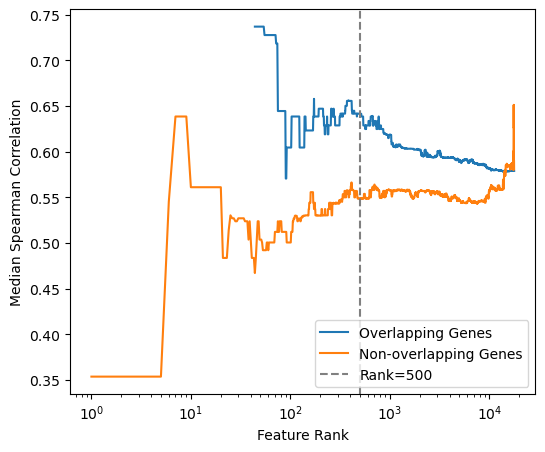

In [60]:
fig, ax = plt.subplots(figsize = (6,5))
sns.lineplot(data = corr_rank, x = 'Feature Rank', y = 'Overlapping Mean Pearson Correlation',
             label='Overlapping Genes', ax = ax)
sns.lineplot(data = corr_rank, x = 'Feature Rank', y = 'Non-overlapping Mean Pearson Correlation',
             label='Non-overlapping Genes', ax = ax)
ax.axvline(x=500, color='grey', linestyle='--', label='Rank=500')
ax.set_ylabel('Median Spearman Correlation')
ax.set_xscale('log')
ax.legend(loc = 'lower right')

# plt.savefig(os.path.join(data_path, 'figures', 'overlapping_pearson_running_rank.png'), 
#             dpi=300, 
#             bbox_inches="tight")
;


Across all feature ranks, those overlapping genes have a higher median spearman correlation than their non-overlapping counterpart. This tells us that the model is actually prioritizing features that reinforce similar biological signal across modalities, rather than selecting features that provide divergent, non-redundant information. 

This is even with the linear SVR regularization parameter, C, as freely tunable in the model. The pipeline selected C = 5.74, which does not enforce stringent regularization of model weights, indicating that the model chose a regularization that allows for multi-collinearity, and consequently, our observations. 

This result shows that, when predicting a y-block phenotype, non-redundancy defined purely by cross-modal correlation is not the dominant factor driving feature importance. In other words, a gene can have high positive correlation across modalities and yet still provide non-redundant information with regards to a y-block phenotype. In the next section, we consider exactly whether features contribute non-redundantly to y.  

In terms of multi-modal analysis, when considering a y-block phenotype, this analysis indicates that feature selection should not necessarily prioritize divergent features. Bellow, we follow up in detail on the overlapping genes, and how they actually contribute to the information available in y, and their relationship to Spearman correlation. 

In [61]:
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*Pipeline instance is not fitted yet.*",
)

def fit_and_get_r2(X, y, best_pipeline):
    best_pipeline_remove = clone(best_pipeline)
    best_pipeline_remove.fit(X, y)
    y_pred = best_pipeline_remove.predict(X)
    return r2_score(y, y_pred)


def dominance_analysis_pair(prot_ft, rna_ft, r2_full):

    protein_cols_sub = [c for c in protein_cols if c != prot_ft]
    rna_cols_sub = [c for c in rna_cols if c != rna_ft]
    X_protein_sub = expr_joint[protein_cols_sub].values
    X_rna_sub = expr_joint[rna_cols_sub].values

    assert X_protein_sub.shape[1] == expr_protein.shape[1] - 1, 'Incorrect feature removal'
    assert X_rna_sub.shape[1] == expr_rna.shape[1] - 1, 'Incorrect feature removal'

    X_p = (X_protein, X_rna_sub)
    X_r = (X_protein_sub, X_rna)
    X_b = (X_protein_sub, X_rna_sub)


    r2_p = fit_and_get_r2(X_p, y, best_pipeline)
    r2_r = fit_and_get_r2(X_r, y, best_pipeline)
    r2_b = fit_and_get_r2(X_b, y, best_pipeline)

    u_r = r2_full - r2_p # rna contribution
    u_p = r2_full - r2_r # protein contribution
#     s = r2_p + r2_r - r2_b
    return {
        'prot_ft': prot_ft, 
        'rna_ft': rna_ft,
            'R2_full': r2_full,
            'unique_rna_contribution': u_r,
            'unique_protein_contribution': u_p,
#             'shared_contribution': s,
            'total pair contribution': r2_full - r2_b, #u_r + u_p + s
        }

In [62]:
if not os.path.isfile(os.path.join(data_path, 'interim', 'dominance_analysis.csv')):

    X = (X_protein, X_rna)
    r2_full = fit_and_get_r2(X, y, best_pipeline)

    # da_res = []
    # for prot_ft in tqdm(prots_in_rankedfts_w_rna):
    #     gene_name = protein_names_dict[prot_ft]
    #     rna_df = ranked_fts_df[
    #         (ranked_fts_df['Gene Name']==gene_name) & (ranked_fts_df['Modality']=='Transcriptomics')
    #     ]
    #     assert rna_df.shape[0]==1
    #     rna_ft = rna_df['Feature Name'].values[0]

    #     res = dominance_analysis_pair(prot_ft, rna_ft, r2_full)
    #     da_res.append(res)


    from joblib import Parallel, delayed
    from tqdm import tqdm

    def dominance_wrapper(prot_ft):
        gene_name = protein_names_dict[prot_ft]

        rna_df = ranked_fts_df[
            (ranked_fts_df['Gene Name'] == gene_name) &
            (ranked_fts_df['Modality'] == 'Transcriptomics')
        ]


        rna_ft = rna_df['Feature Name'].values[0]
        return dominance_analysis_pair(prot_ft, rna_ft, r2_full)

    # --- Parallel execution with progress bar ---
    da_res = Parallel(n_jobs=n_cores)(   # -1 = use all cores
        delayed(dominance_wrapper)(prot_ft)
        for prot_ft in tqdm(prots_in_rankedfts_w_rna)
    )

    da_res = pd.DataFrame(da_res)
    da_res.to_csv(os.path.join(data_path, 'interim', 'dominance_analysis.csv'))
    
else:
    da_res = pd.read_csv(os.path.join(data_path, 'interim', 'dominance_analysis.csv'), index_col = 0)

In [63]:
da_res['spearman_correlation'] = pd.Series(zip(da_res.prot_ft, da_res.rna_ft)).map(
    dict(zip(list(zip(spearman_corr_df.prot_ft, spearman_corr_df.rna_ft)), spearman_corr_df.r))
)
da_res['rank'] = range(1, da_res.shape[0] + 1)
# da_res['additive_contribution'] = da_res['unique_protein_contribution'] + da_res['unique_rna_contribution']
da_res.head()

,prot_ft,rna_ft,R2_full,unique_rna_contribution,unique_protein_contribution,total pair contribution,spearman_correlation,rank
0,sp|P43360|MAGA6_HUMAN,MAGEA6 (4105),0.926777,0.000017,0.000111,0.000135,0.353764,1
1,sp|Q96GU1|PAGE5_HUMAN,PAGE5 (90737),0.926777,-0.000002,0.000004,0.000003,0.736923,2
2,sp|Q14956-2|GPNMB_HUMAN,GPNMB (10457),0.926777,0.000057,0.000127,0.000204,0.638526,3
3,sp|Q96A00|PP14A_HUMAN,PPP1R14A (94274),0.926777,-0.000013,0.000046,0.000031,0.483691,4
4,sp|Q6NT55|CP4FN_HUMAN,CYP4F22 (126410),0.926777,-0.000004,0.000044,0.000043,NaN,5


The above dataframe gives the following information: 
   - total pair contribution: change in model performance without the feature pair (r2_full - r2_b, where r2_b is the baseline without either feature)
   - unique_rna_contribution: change in model performance without the mRNA feature 
   - unique_protein_contribution: change in model performance without the protein feature
   - DEPR additive contribution: unique_rna_contribution + unique_protein_contribution; compare to total pair contribution

''

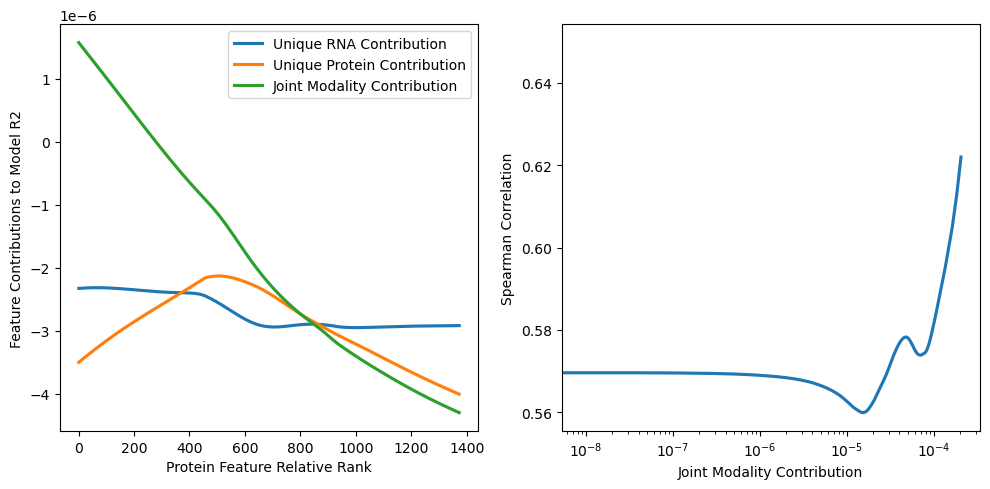

In [47]:
fig, ax = plt.subplots(figsize = (10,5), ncols = 2)

cols = ['unique_rna_contribution', 'unique_protein_contribution', 'additive_contribution', 'total pair contribution']
col_map = dict(zip(
    cols,
    ['Unique RNA Contribution', 'Unique Protein Contribution', 
           'Additive Contribution of Each Unique Modlaity', 'Joint Modality Contribution']
))

j = 0
#'additive_contribution',
for col in ['unique_rna_contribution', 'unique_protein_contribution',  'total pair contribution']:
    sns.regplot(data = da_res, x = 'rank', y = col, label = col_map[col], ax = ax[j], 
                scatter = False, lowess = True, ci=False, 
            line_kws={"linestyle": "--" if col == 'additive_contribution' else '-'} 
               )
#     sns.lineplot(data = da_res, x = 'rank', y = col, label = col_map[col], ax = ax[j])

# ax[j].set_yscale('log')
ax[j].set_ylabel('Feature Contributions to Model R2')
ax[j].set_xlabel('Protein Feature Relative Rank')
ax[j].legend()

j = 1
col = 'total pair contribution'
sns.regplot(data = da_res, y = 'spearman_correlation', x = col, ax = ax[j], 
            scatter = False, lowess = True, ci=True, 
        line_kws={"linestyle": "--" if col == 'additive_contribution' else '-'} 
           )
ax[j].set_xlabel(col_map[col])
ax[j].set_ylabel('Spearman Correlation')
ax[j].set_xscale('log')

fig.tight_layout()
;

- Left panel: 
    - Each individual protien, mRNA, and protein-RNA feature pair contributes only a very small amount to the variance in y. The model’s predictive performance arises from aggregating information across many such features, not from any single pair.
    - At larger relative ranks up to ~700 protein features, the joint contribution tends to be larger than either individual feature, indicating that accounting for both features benefits the model. 
    - Joint contribution decreases as protein-feature rank increases. Higher-ranked (more important) protein features tend to form cross-modality pairs that contribute more to y, even if the information is redundant according to the previous Spearman analysis. 
    - As we increase in rank, joint contribution becomes negative, indicating that these pairs contribute marginal noise relative to the full model. This does not contradict hyperparameter tuning: the effects are extremely small (on the order of 10⁻⁶), and the model's performance is dominated by the collective effect of thousands of features. Hyperparameter tuning optimizes global predictive performance, so it does not remove features whose individual marginal contribution is minuscule.
- Right panel: The joint modality contribution has a positive relationship with Spearman correlation, particularly at larger contributions. If we take Spearman correlation as a proxy for "redundancy", this does reinforce the conclusions of the overlapping vs non-overlapping analysis that higher redundancy pairs are more informative of *y*, contributing strong, consistent biological signal.


Overall, the overlapping vs non-overlapping and dominance analysis tells us:
- Genes with stronger RNA↔protein coupling carry true biological variance that predicts y. The model leverages this coherence.
- In multi-omic models, high RNA-protein correlation often reflects actionable biology: strong central drivers, less technical noise, and high detectability in both assays
- The fact that, in instances whereh both features are available, shared contribution > unique contributions, indicates that the model learns signal that is encoded jointly across modalities.


Finally, these analyses only considered the proteins that *were* selected by the join model. Let's repeat the correlation analysis for all 10202 intersecting features, and compare those that were excluded by the model to those that were selected:

In [64]:
scd_all = {'Protein Feature': [], 
          'Spearman Correlation': []}

rev_protein_mapper = {v:k for k,v in protein_mapper.items()}
rev_rna_mapper = {v:k for k,v in rna_mapper.items()}

for gene_name in tqdm(intersect_names):
    prot_ft = rev_protein_mapper[gene_name]
    rna_ft = rev_rna_mapper[gene_name]
    
    r = calc_corr(values_df=data_df, ft1_id=prot_ft, ft2_id=rna_ft, 
                 corr_type='spearman', 
#                      control_mean = False, 
                 ft1_thresh = protein_thresh, 
                 ft2_thresh = rna_thresh,
                 min_samples = 10, 
                )
    scd_all['Protein Feature'].append(prot_ft)
    scd_all['Spearman Correlation'].append(r)
    
scd_all = pd.DataFrame(scd_all)

selected_features = model_coefs['Feature Name'].tolist()
scd_all['Selected'] = scd_all['Protein Feature'].apply(lambda x: x in selected_features)


100%|███████████████████████████████████| 10202/10202 [00:03<00:00, 3066.42it/s]


In [65]:
scd_all['Selected_ylabel'] = pd.Categorical(
    scd_all.Selected.map({True: 'Selected', False: 'Not Selected'}), 
    ordered = True, categories = ['Selected', 'Not Selected'])


''

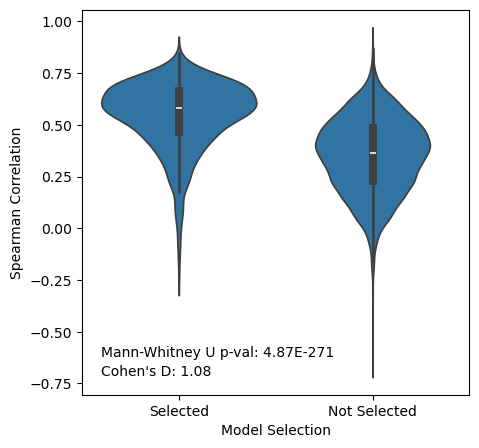

In [66]:
selected_corr = scd_all[scd_all.Selected]['Spearman Correlation']
not_selected_corr = scd_all[~scd_all.Selected]['Spearman Correlation']

nan_mask = scd_all['Spearman Correlation'].notna()
selected_corr = scd_all[scd_all.Selected & nan_mask]['Spearman Correlation'].tolist()
not_selected_corr = scd_all[~scd_all.Selected & nan_mask]['Spearman Correlation'].tolist()

pval = stats.mannwhitneyu(selected_corr, not_selected_corr, alternative = 'two-sided').pvalue
cd = cohen_d(selected_corr, not_selected_corr)

fig, ax = plt.subplots(figsize = (5,5))
sns.violinplot(data = scd_all, x = 'Selected_ylabel', y = 'Spearman Correlation', ax = ax)
ax.set_xlabel('Model Selection')
ax.annotate("Mann-Whitney U p-val: {:.2E}".format(pval), xy=(0.05, 0.1), xycoords='axes fraction')
ax.annotate("Cohen's D: {:.2f}".format(cd), xy=(0.05, 0.05), xycoords='axes fraction')
;

Again, the model selection demonstrates the model prefers features with higher correlation. Let's also look at the fraction of protein features present and combine all our analyses. 

In [67]:
msg = 'Whereas all {} RNA features were selected in the model, '.format(len(selected_rna_cols))
msg += 'only {} of the protein features were selected'.format(len(selected_protein_cols))
protein_frac_all = len(selected_protein_cols)/len(selected_cols)
assert protein_frac_all == model_coefs.iloc[-1,:].loc['Protein Feature Fraction'], 'Incorrect calculation of protein feature fraction'

protein_frac_all *= 100
msg += '. Thus, protein features comprise {:.2f}% of all features used in the model'.format(protein_frac_all) 

protein_frac = 100*model_coefs[model_coefs['Feature Rank'] == 500]['Protein Feature Fraction'].tolist()[0]
msg +='. They comprise {:.2f}% of the top 500 features'.format(protein_frac)

print(msg)

Whereas all 16371 RNA features were selected in the model, only 1475 of the protein features were selected. Thus, protein features comprise 8.27% of all features used in the model. They comprise 36.60% of the top 500 features


''

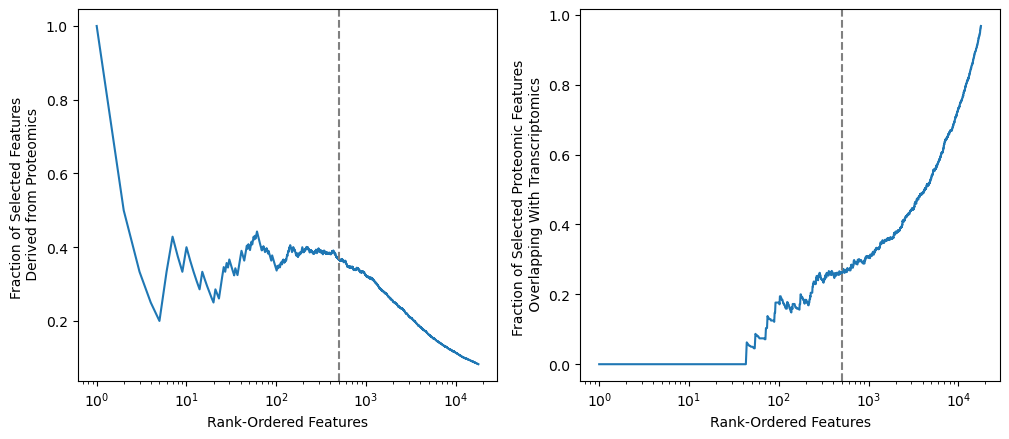

In [68]:
ncols = 2
nrows = 1

fig, axes = plt.subplots(ncols = ncols, nrows = nrows, figsize = (ncols * 5.1, nrows*4.5))
ax = np.ravel([axes])



j = 0
sns.lineplot(data = model_coefs, x = 'Feature Rank', y = 'Protein Feature Fraction', 
            ax = ax[j])
ax[j].set_xlabel('Rank-Ordered Features')
ax[j].set_xscale('log')
ax[j].set_ylabel('Fraction of Selected Features \n Derived from Proteomics')
ax[j].axvline(x=500, color='gray', linestyle='--')

j = 1
sns.lineplot(data = model_coefs, x = 'Feature Rank', y = 'Shared Genes Fraction - Protein', 
             ax = ax[j])
ax[j].set_xlabel('Rank-Ordered Features')
ax[j].set_xscale('log')
ax[j].set_ylabel('Fraction of Selected Proteomic Features \n Overlapping With Transcriptomics')
ax[j].axvline(x=500, color='gray', linestyle='--')
fig.tight_layout()
;



Regarding the first panel, this suggests a weighting of proteomics in the top features, which aligns with the fact that they help improve predictive performance.

Regarding the second panel, this tells us that while features representing the same gene between transcriptomics and proteomics do add information,they are substantially less heavily favored in the more influential set of top-ranked features (fewer features are shared in the top 500 than in all features used in the dataset).

Let's quantitate this using over-representation analysis:

For the fraction of proteomics, we can test whether there is an enrichment of proteomic features in the top 500 features. A contingency matrix testing for enrichment of Pathway A in a gene list will look as follows:

enrichment of missing/imputed values for the under-predicted genes. 

|                   | In Pathway A               | Not in Pathway A               |
|-------------------|----------------------------|--------------------------------|
| Pathway A         | Count of genes in both       | Count of genes in "Pathway A"  |
|                   | "Pathway A" and your gene    | but not in your gene list      |
|                   | list (observed)             | (expected under null hypothesis)|
|-------------------|----------------------------|--------------------------------|
| Not Pathway A     | Count of genes not in        | Count of genes not in          |
|                   | "Pathway A" but in your      | "Pathway A" and not in your     |
|                   | gene list (observed)         | gene list (expected under null  |
|                   |                            | hypothesis)                     |

Here we test for over-representation of the proteomic modality in the top ranked features:

| Modality            | Top *n* Features | Outside Top *n* | Total |
|---------------------|------------------|-----------------|-------|
| Proteomics          | a                | b               | a + b |
| Transcriptomics     | c                | d               | c + d |
| Total               | a + c            | b + d           | N     |


- a: Proteomic features within the top n ranks.
- b: Proteomic features outside the top n ranks.
- c: Transcriptomic features within the top n ranks.
- d: Transcriptomic features outside the top n ranks.


We also test for depletion of proteomic features that have a transcriptomic counterpart:
| Proteomic features  | Top *n* Features | Outside Top *n* | Total |
|---------------------|------------------|-----------------|-------|
| Overlapping         | a                | b               | a + b |
| Non-overlapping     | c                | d               | c + d |
| Total               | a + c            | b + d           | N     |


- a: Proteomic features overlapping with transcriptomic features within the top n ranks.
- b: Proteomic features overlapping with transcriptomic features outside the top n ranks.
- c: Proteomic features not overlapping with transcriptomic features within the top n ranks.
- d: Proteomic features not overlapping with transcriptomic features outside the top n ranks.


In [69]:
def proteomic_ora(model_coefs, n, verbose = False):
    # Define contingency table
    top_n = model_coefs[model_coefs["Feature Rank"] <= n]
    outside_top_n = model_coefs[model_coefs["Feature Rank"] > n]
    
    # Calculate counts for contingency table
    a = (top_n["Modality"] == "Proteomics").sum() # proteomic features in top n
    c = (top_n["Modality"] == "Transcriptomics").sum() 
    b = (outside_top_n["Modality"] == "Proteomics").sum()
    d = (outside_top_n["Modality"] == "Transcriptomics").sum()
    
    N = model_coefs.shape[0] # total features
    K = a + b # total number of protein features
    k = a # total number of protein features in top n
    
#     hypergeom_p = hypergeom(M=N, n=K, N=n).sf(k-1)
    
    # Calculate odds ratio
    odds_ratio, fisher_p = fisher_exact([[a, b], [c, d]], alternative = 'greater')
    if verbose: 
        msg = 'At a feature rank of {}'.format(n)
        msg += " the Fisher's exact test p-value for over-representation of proteomic features is"
        msg += " {:.3f}, with an odds ratio of {:.2f}".format(fisher_p, odds_ratio)
        print(msg)

    return odds_ratio, fisher_p

    
def shared_ora(model_coefs, n, verbose = False):
    # Define contingency table
    top_n = model_coefs[model_coefs["Feature Rank"] <= n]
    outside_top_n = model_coefs[model_coefs["Feature Rank"] > n]
    
    _, prot_genes_top, common_genes_top, diff_genes_top = get_shared_genes(top_n, get_prot_difference = True)
    _, prot_genes_out, common_genes_out, diff_genes_out = get_shared_genes(outside_top_n, get_prot_difference = True)

    
    # Calculate counts for contingency table
    a = len(common_genes_top) 
    c = len(diff_genes_top)
    b = len(common_genes_out)
    d = len(diff_genes_out)

    # Calculate odds ratio
    odds_ratio, fisher_p = fisher_exact([[a, b], [c, d]], alternative = 'less')

    
    if verbose: 
        msg = 'At a feature rank of {}'.format(n)
        msg += " the Fisher's exact test p-value for depletion of proteomic features that"
        msg += " are shared with transcriptomic features is"
        msg += " {:.3e}, with an odds ratio of {:.2f}".format(fisher_p, odds_ratio)
        print(msg)
    return odds_ratio, fisher_p
    

In [70]:
odds_ratio_proteomic, fisher_p_proteomic = proteomic_ora(model_coefs, n = 500, verbose = True)

At a feature rank of 500 the Fisher's exact test p-value for over-representation of proteomic features is 0.000, with an odds ratio of 7.17


In [71]:
odds_ratio_shared, fisher_p_shared = shared_ora(model_coefs, n = 500, verbose = True)

At a feature rank of 500 the Fisher's exact test p-value for depletion of proteomic features that are shared with transcriptomic features is 8.953e-68, with an odds ratio of 0.05


# Nikos Suggested Analysis

In [157]:
rank = 500
n_permutations = 1000
seed = 888


assert model_coefs.index.nunique() == model_coefs.shape[0], 'Must reset index for permutation'

def count_modality(df, rank = 500):

    # define whether a feature at a rank is overlapping or not
    df = df.iloc[:rank, :].copy()
#     rev_mmap = {'Transcriptomics': 'Proteomics', 
#                'Proteomics': 'Transcriptomics'}

#     ols = []
#     for i in range(rank):
#         row = df.iloc[i,:]

#         feature_modality = row['Modality']
#         gene_name = row['Gene Name']

#         opposite_modality = rev_mmap[feature_modality]

#         top_n = df.iloc[:i-1].copy()
#         opposite_modality_gene_names = top_n[top_n.Modality == opposite_modality]['Gene Name'].tolist()

#         if gene_name in opposite_modality_gene_names:
#             overlapping_label = True
#         else:
#             overlapping_label = False
#         ols.append(overlapping_label)
#     df['Overlapping'] = ols

#     modality_counts = df[['Overlapping', 'Modality']].value_counts()
#     U_t = modality_counts.get((False, 'Transcriptomics'), 0) # non-overlapping transcript counts
#     U_p = modality_counts.get((False, 'Proteomics'), 0) # non-overlapping proteomic counts

    proteomics = df[df.Modality == 'Proteomics']
    transcriptomics = df[df.Modality == 'Transcriptomics']

    transcriptomics_genes = set(transcriptomics['Gene Name'])
    proteomics_genes = set(proteomics['Gene Name'])

#     n_overlapping = len(proteomics_genes.intersection(transcriptomics_genes))

    U_t = len(transcriptomics_genes.difference(proteomics_genes)) # non-overlapping transcript counts
    U_p = len(proteomics_genes.difference(transcriptomics_genes))  # non-overlapping proteomic counts

    return U_p - U_t
    
    
diff = count_modality(df = model_coefs, rank = 500)

# create null distribution
rng = np.random.default_rng(seed)
null_diffs = [] #, null_pcs = [], []
for i in trange(n_permutations):
    perm_idx = rng.permutation(model_coefs.index)
    null_diff = count_modality(model_coefs.loc[perm_idx], rank = rank)
    null_diffs.append(null_diff)
    
null_diffs = np.array(null_diffs)
    
# one-sided test that non-overlapping difference is > expected given null  
pval_diff = (np.sum(null_diffs >= diff) + 1) / (len(null_diffs) + 1)

print('The p-value that the difference in non-overlapping proteomics genes and transcriptomic genes is larger than expected given a null is {:.2E}'.format(pval_diff))


100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 510.57it/s]

The p-value that the difference in non-overlapping proteomics genes and transcriptomic genes is larger than expected given a null is 9.99E-04


Nikos: "it seems that if a feature is not-overlapping between proteomics and transcriptomics and it is selected on the top features, it is likely to be a protein. That means there is definitely value using proteomics as biologists like to do"

# end nikos suggested analysis

''

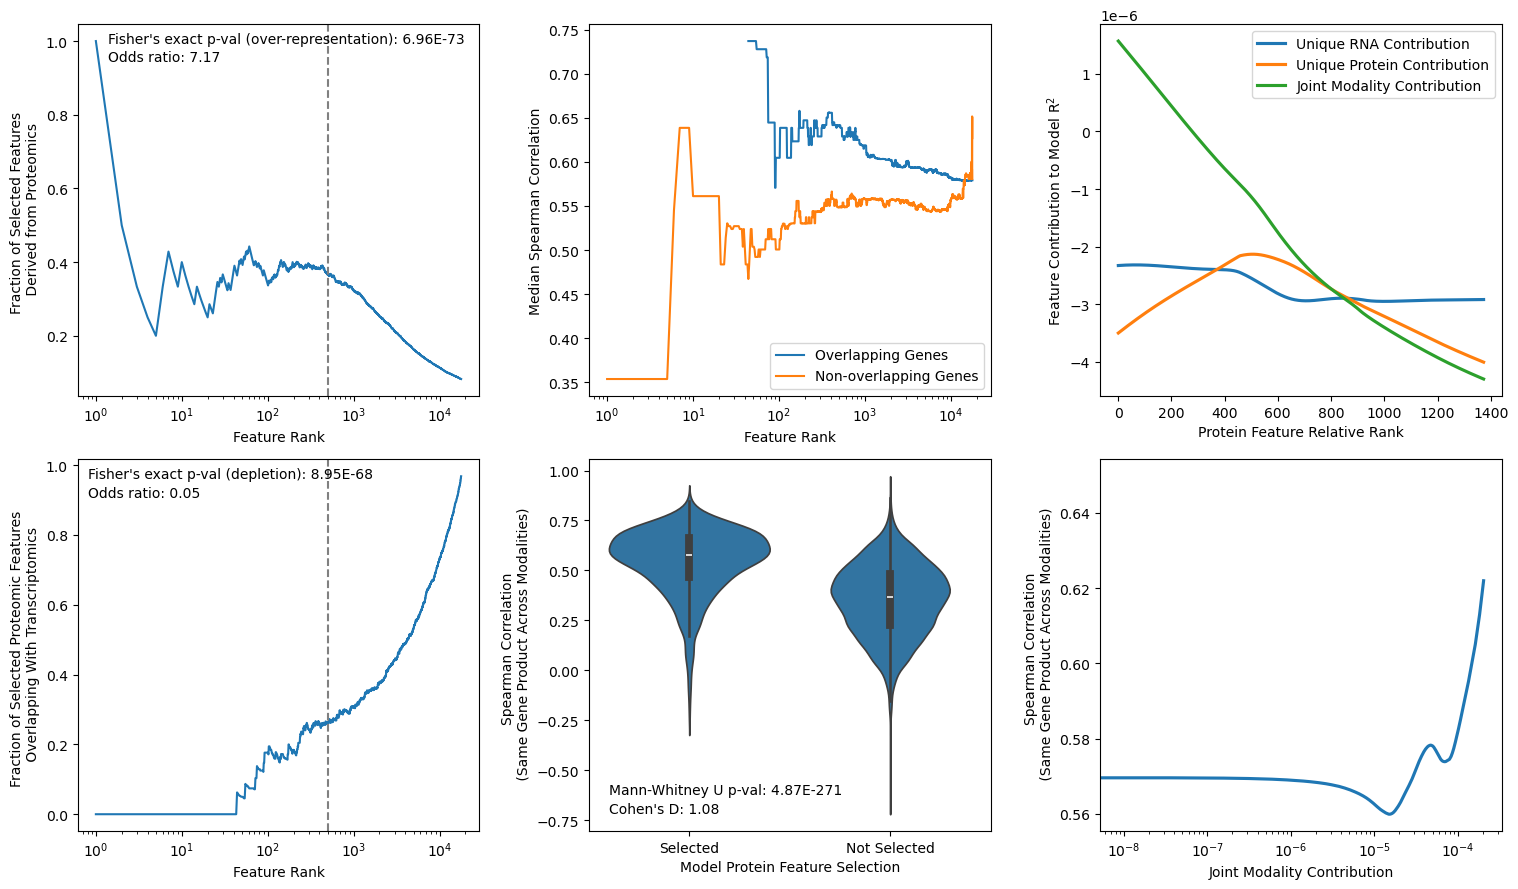

In [37]:
ncols = 3
nrows = 2

fig, axes = plt.subplots(ncols = ncols, nrows = nrows, figsize = (ncols * 5.1, nrows*4.5))
ax = np.ravel([axes])

j = 0
sns.lineplot(data = model_coefs, x = 'Feature Rank', y = 'Protein Feature Fraction', 
            ax = ax[j])
ax[j].set_xlabel('Feature Rank')
ax[j].set_xscale('log')
ax[j].set_ylabel('Fraction of Selected Features \n Derived from Proteomics')
ax[j].axvline(x=500, color='gray', linestyle='--')

ax[j].annotate("Fisher's exact p-val (over-representation): {:.2E}".format(fisher_p_proteomic), xy=(0.075, 0.95), xycoords='axes fraction')
ax[j].annotate("Odds ratio: {:.2f}".format(odds_ratio_proteomic), xy=(0.075, 0.9), xycoords='axes fraction')

j = 3
sns.lineplot(data = model_coefs, x = 'Feature Rank', y = 'Shared Genes Fraction - Protein', 
             ax = ax[j])
ax[j].set_xlabel('Feature Rank')
ax[j].set_xscale('log')
ax[j].set_ylabel('Fraction of Selected Proteomic Features \n Overlapping With Transcriptomics')
ax[j].axvline(x=500, color='gray', linestyle='--')

ax[j].annotate("Fisher's exact p-val (depletion): {:.2E}".format(fisher_p_shared), xy=(0.025, 0.95), xycoords='axes fraction')
ax[j].annotate("Odds ratio: {:.2f}".format(odds_ratio_shared), xy=(0.025, 0.9), xycoords='axes fraction')



# correlation: overlapping vs non-overlapping genes in model selection
j = 1
sns.lineplot(data = corr_rank, x = 'Feature Rank', y = 'Overlapping Mean Pearson Correlation',
             label='Overlapping Genes', ax = ax[j])
sns.lineplot(data = corr_rank, x = 'Feature Rank', y = 'Non-overlapping Mean Pearson Correlation',
             label='Non-overlapping Genes', ax = ax[j])
# ax[j].axvline(x=500, color='gray', linestyle='--')
ax[j].set_ylabel('Median Spearman Correlation')
ax[j].set_xscale('log')
ax[j].legend(loc = 'lower right')

# correlation: selected vs unselected
j = 4
selected_corr = scd_all[scd_all.Selected]['Spearman Correlation']
not_selected_corr = scd_all[~scd_all.Selected]['Spearman Correlation']

nan_mask = scd_all['Spearman Correlation'].notna()
selected_corr = scd_all[scd_all.Selected & nan_mask]['Spearman Correlation'].tolist()
not_selected_corr = scd_all[~scd_all.Selected & nan_mask]['Spearman Correlation'].tolist()

pval = stats.mannwhitneyu(selected_corr, not_selected_corr, alternative = 'two-sided').pvalue
cd = cohen_d(selected_corr, not_selected_corr)

sns.violinplot(data = scd_all, x = 'Selected_ylabel', y = 'Spearman Correlation', ax = ax[j])
ax[j].set_xlabel('Model Protein Feature Selection')
ax[j].annotate("Mann-Whitney U p-val: {:.2E}".format(pval), xy=(0.05, 0.1), xycoords='axes fraction')
ax[j].annotate("Cohen's D: {:.2f}".format(cd), xy=(0.05, 0.05), xycoords='axes fraction')
ax[j].set_ylabel('Spearman Correlation \n (Same Gene Product Across Modalities)')

# Dominance Analysis
cols = ['unique_rna_contribution', 'unique_protein_contribution', 'additive_contribution', 'total pair contribution']
col_map = dict(zip(
    cols,
    ['Unique RNA Contribution', 'Unique Protein Contribution', 
           'Additive Contribution of Each Unique Modlaity', 'Joint Modality Contribution']
))

# Feature contributions: individual vs combined
j = 2
#  'additive_contribution', 
for col in ['unique_rna_contribution', 'unique_protein_contribution', 'total pair contribution']:
    sns.regplot(data = da_res, x = 'rank', y = col, label = col_map[col], ax = ax[j], 
                scatter = False, lowess = True, ci=False, 
            line_kws={"linestyle": "--" if col == 'additive_contribution' else '-'} 
               )

# ax[j].set_xscale('log')
ax[j].set_ylabel("Feature Contribution to Model R$^2$")
ax[j].set_xlabel('Protein Feature Relative Rank')
ax[j].legend()

# Feature contributions vs Spearman Correlation
j = 5
col = 'total pair contribution'
sns.regplot(data = da_res, y = 'spearman_correlation', x = col, ax = ax[j], 
            scatter = False, lowess = True, ci=True, 
        line_kws={"linestyle": "--" if col == 'additive_contribution' else '-'} 
           )
ax[j].set_xlabel(col_map[col])
ax[j].set_ylabel('Spearman Correlation \n (Same Gene Product Across Modalities)')
ax[j].set_xscale('log')

fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'joint_feature_running_rank.png'), 
            dpi=300, 
            bbox_inches="tight")

;

Altogether -- see in combination with above discussions of individual panels:
- Panel 1: More transcriptomic features are selected than proteomics, but when proteomics are selected, they are enriched for top-ranking ones. This supports the notion that proteomic features, when selected, positively contribute to metastatic information. 
- Panel 2: Nearly all selected proteomic features overlap with those in the transcriptomics (all transcriptomics are selected). However, in the top-ranking features, there is a depletion in overlap, indicating the model selects distinct gene products across modalities, likely because they carry distinct information. 
- Panel 3: When the model *does* select overlapping gene products, these contain highly consistent information by way of Spearman correlation, even higher than non-overlapping ones. This means the model tends to select overlapping features when the modalities agree, i.e., when RNA and protein measurements reflect consistent biology. Thus, this information should not be considered redundant, but rather, consistent. 
- Panel 4: The conclusion of panel 3 is extended to selected vs unselected proteomic features -- those that are selected have higher Spearman correlation with their transcriptomic counterpart. 
- Panel 5: When considering overlapping features direct effect on model performance, rather than Spearman correlation, their combination does improve prediction relative to the individual modalities. This combinatorial improvement indicates that—even when modalities are correlated—their combination captures non-redundant predictive structure related to the phenotype. Thus, high cross-modal consistency (Panel 3) does not imply statistical redundancy with respect to the y-block.
- **Panel 6**: Higher RNA–protein Spearman correlations are associated with greater joint contribution to predictive performance. This supports the unifying conclusion from Panels 3–5: Pairs with strong cross-modal coherence encode biologically meaningful variation relevant to metastatic potential, and are therefore prioritized by the model. **Correlation alone does not tell the full story in terms of information on y -- high correlation does not mean low marginal information from incorporating the second modality**

Proteomic features are selectively enriched for strong predictors (Panels 1–2).Cross-modal agreement signals biologically relevant gene programs (Panels 3–4). Synergy, not redundancy, explains why correlated protein–RNA pairs help prediction (Panels 5–6).

A nuance: Top-ranked protein features are less likely to have an overlapping transcriptomic partner (Panel 2)
→ Suggests distinct info is preferred at top ranks. BUT Overlapping pairs have stronger correlation and stronger joint contributions (Panels 3–6) → Suggests adding both modalities together is beneficial. These do not necessarily contradict each other, but rather reveal two regimes of model behavior: Regime A (top ranks): The model selects proteins with unique value not captured by RNA. Overlap is depleted because the RNA counterpart probably carries similar info already captured elsewhere. Regime B (mid-to-low ranks): Overlapping RNA–protein pairs act as stabilizing, redundant-but-useful features. Thus, early ranks maximize new information whereas later ranks reinforce biological signal via consistency across modalities. 


This aligns in a way with the results of B/04; the lack of difference or weak statistical associations can be explained by the fact that the model prefers the same information and uses them similarly.

Joint omics model supports results of individual -- more transcriptomic features selected than proteomics; proteomics does not confer an advantage and transcriptomics a weak one because it carries the same information and the model prefers those features where information is the same, anyways. 

In [48]:
# fns = [os.path.join(data_path, 'processed',  'expr_joint.csv'),
# os.path.join(data_path, 'processed', 'uniprot_mapper.json'),
# os.path.join(data_path, 'processed', 'rank_ordered_joint_features.csv'),
# '/home/hmbaghda/Projects/metastatic_potential/notebooks/C_joint_prediction/*.txt']

# for fn in fns:
#     cmd = 'scp hmbaghda@satori-login-002.mit.edu:' + fn
#     cmd += ' Downloads/for_Arjana/.'
#     print(cmd)

We will run ORA on the positive and negative coefficients from the top 500 features separately. 

In [86]:
top_n = 500 # features to run through ora
top_p = 20 # pathways to visualize


In [67]:
if not os.path.isfile(os.path.join(data_path, 'interim', 'join_coefs_for_ora.csv')):
    model_coefs.to_csv(os.path.join(data_path, 'interim', 'join_coefs_for_ora.csv'))

model_coefs = pd.read_csv(os.path.join(data_path, 'interim', 'join_coefs_for_ora.csv'), index_col = 0)
top_model_coefs = model_coefs.iloc[:top_n].copy()

background = sorted(set(protein_names).union(rna_names))
mi['top500'] = goi + [np.nan]*(len(background)- len(goi))
mi.set_index('_BACKGROUND', inplace = True)

fn_ora = os.path.join(data_path, 'interim/', 'joint_metascape_input.csv')
mi.to_csv(fn_ora)

In [94]:
sort_by = 'zscore' #'pval'
ms = pd.read_excel(os.path.join(data_path, 'processed', 'joint_metascape_result.xlsx'), 
                       sheet_name = 'Enrichment',
                       index_col = None)
ms_all = pd.read_csv(os.path.join(data_path, 'processed', 'joint_GO_AllLists.csv'), 
                    index_col = 0)

# get average z-score per summary term from the individual members
ms_members = ms[ms['GroupID'].apply(lambda x: x.endswith('_Member'))].copy()
if ms_members.Term.nunique() != ms_members.shape[0]:
    raise ValueError('Expected unique terms')

zscores = []
for term in ms_members.Term:
    ms_term = ms_all[ms_all.GO == term]
    if ms_term.shape[0] > 1:
        raise ValueError('Expected 1 unique term')
    elif ms_term.shape[0] == 0:
        zscores.append(np.nan)
    else:
        zscores.append(ms_term['Z-score'].values.tolist()[0])
ms_members['Z-score'] = zscores

term_zscore = ms_members.groupby('GroupID')['Z-score'].mean().to_dict()
term_zscore = {k.split('_')[0]:v for k,v in term_zscore.items()}

ms = ms[ms['GroupID'].apply(lambda x: x.endswith('_Summary'))]
ms.reset_index(drop = True, inplace = True)
ms['Z-score'] = ms['GroupID'].apply(lambda x: term_zscore[x.split('_')[0]])


# formatting
ms['q-value'] = 10**ms['Log(q-value)']
ms = ms[ms['q-value'] <= 0.1]
ms['-Log10(q-value)'] = -ms['Log(q-value)']
if ms['Z-score'].min() < 0:
    raise ValueError('Sorted according to assumption that all Z-scores to be positive')
if sort_by == 'zscore':
    ms.sort_values(by = ['Z-score','Log(q-value)'], ascending=[False, True], inplace = True) 
elif sort_by == 'pval':
    # sort by q-value, tie break with z-score
    ms.sort_values(by = ['Log(q-value)', 'Z-score'], ascending=[True, False], inplace = True) 
else:
    raise ValueError('Specificy a sort column')

ms.reset_index(drop = True, inplace = True)


/tmp/ipykernel_876803/1883475501.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm_matplot.get_cmap('YlOrBr_r')
/tmp/ipykernel_876803/1883475501.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = ms_topn, x = 'Description', y = y_col,
/tmp/ipykernel_876803/1883475501.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels,
/tmp/ipykernel_876803/1883475501.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the 

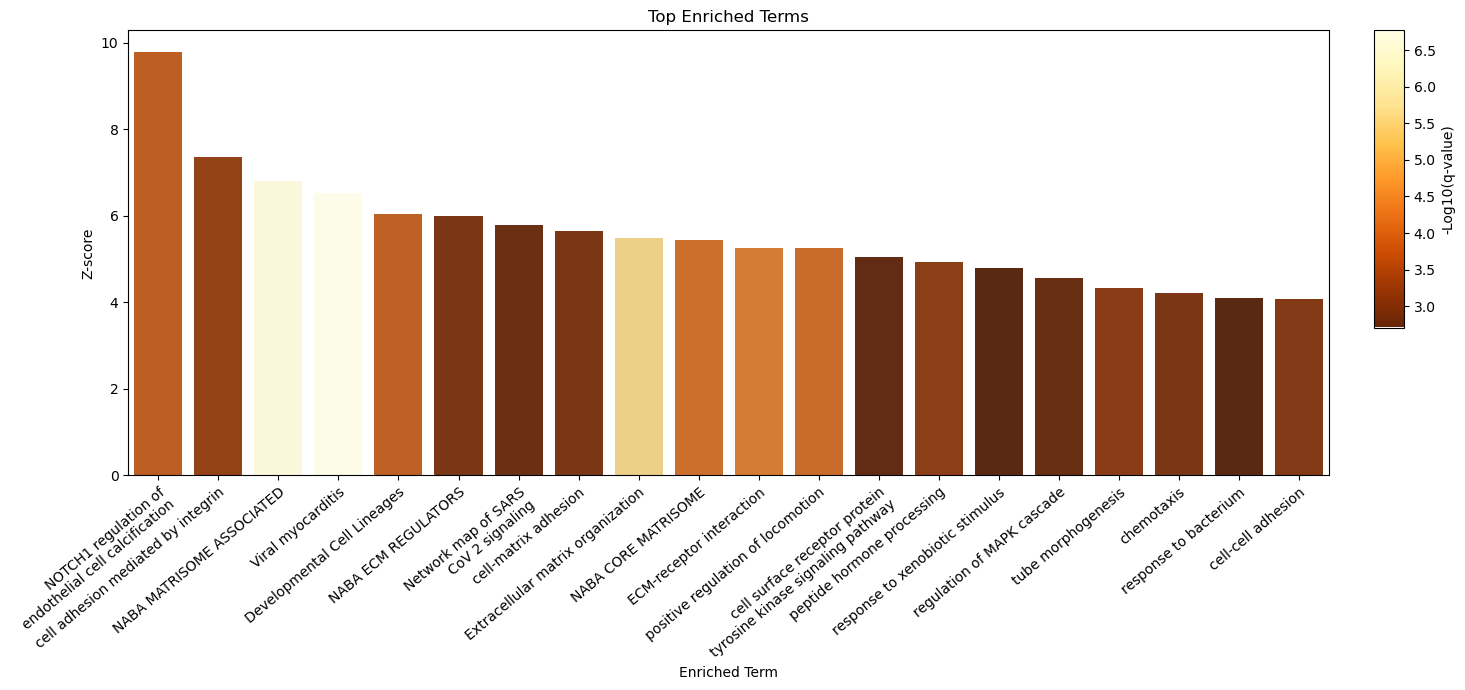

In [95]:
fig, ax = plt.subplots(figsize = (15, 7))

ms_topn = ms.iloc[:top_p, :].copy()



if sort_by == 'zscore':
    color_col = '-Log10(q-value)'
    y_col = 'Z-score'
elif sort_by == 'pval':
    color_col = 'Z-score' 
    y_col = '-Log10(q-value)'
norm = Normalize(vmin=ms_topn[color_col].min(), vmax=ms_topn[color_col].max())
cmap = cm_matplot.get_cmap('YlOrBr_r')
colors = [cmap(norm(val)) for val in ms[color_col]]
cbar_ax = fig.add_axes([0.92, 0.525, 0.02, 0.425])  # [left, bottom, width, height]
# pos = ax.get_position()  # Returns a Bbox object
# cbar_width = 0.02  # Width of the colorbar
# cbar_padding = 0.02  # Space between subplot and colorbar
# cbar_ax = fig.add_axes([pos.x1 + cbar_padding, pos.y0, cbar_width, pos.height])  # [left, bottom, width, height]
colorbar = plt.colorbar(cm_matplot.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
colorbar.set_label(color_col)


sns.barplot(data = ms_topn, x = 'Description', y = y_col, 
            palette = colors, ax = ax)

xlabels = []
for x_label in ax.get_xticklabels():
    xlabels.append(middle_break(x_label._text, len_thresh = 35))

ax.set_xticklabels(xlabels, 
                   rotation=40, va = 'top',
                   ha="right", rotation_mode="anchor")
# ax.get_legend().remove()
ax.set_title('Top Enriched Terms')
ax.set_xlabel('Enriched Term')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.savefig(os.path.join(data_path, 'figures', 'joint_feature_ora.png'), 
            dpi=300, 
            bbox_inches="tight")

Amongst the top 20 enriched terms, we see pathways directly associated to cell migration, those related to cell coordination and ECM remodeling, as well as terms indicating of activation of inflammatory pathways. 

In [96]:
fns = [#os.path.join(data_path, 'figures', 'overlapping_pearson_running_rank.png'),
os.path.join(data_path, 'figures', 'joint_feature_running_rank.png'), 
      os.path.join(data_path, 'figures', 'joint_feature_ora.png')]

for fn in fns:
    cmd = 'scp hmbaghda@orcd-login001.mit.edu:' + fn
    cmd += ' Downloads/figures/.'
    print(cmd)

scp hmbaghda@orcd-login001.mit.edu:/home/hmbaghda/orcd/pool/metastatic_potential/figures/joint_feature_running_rank.png Downloads/figures/.
scp hmbaghda@orcd-login001.mit.edu:/home/hmbaghda/orcd/pool/metastatic_potential/figures/joint_feature_ora.png Downloads/figures/.
